In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import os
import cv2
from os import walk
import glob as gb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATADIR = r'./Data/'
TRAIN_DATADIR = os.path.join(DATADIR, 'Train_Data')
TEST_DATADIR = os.path.join(DATADIR, 'Test_Data')

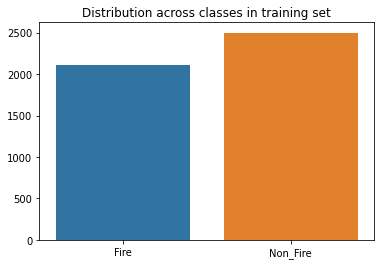

Total Train Examples = 4608


In [3]:
class_names = []
class_count = []
TRAIN_EXAMPLES = 0
for folder in  os.listdir(TRAIN_DATADIR) : 
    files = gb.glob(pathname= str( TRAIN_DATADIR + '//' + folder + '/*.jpg'))
    class_names.append(folder)
    class_count.append(len(files))
    TRAIN_EXAMPLES += len(files)
    
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in training set")
plt.show()

print(f'Total Train Examples = {TRAIN_EXAMPLES}')

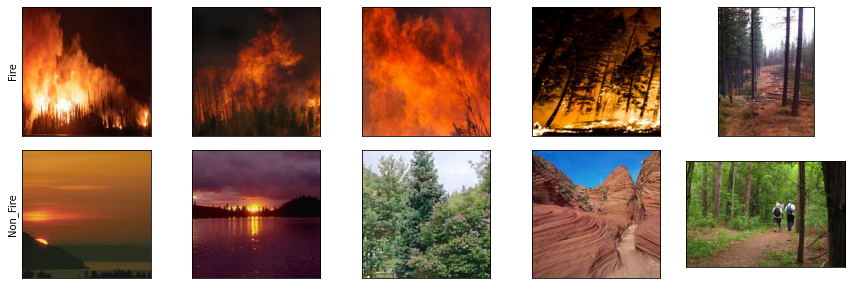

In [4]:
plt.figure(figsize=(12,12))
i=0
for c in os.listdir(TRAIN_DATADIR):  
    path = os.path.join(TRAIN_DATADIR,c)
    for img in os.listdir(path):
        img_array = cv2.cvtColor(cv2.imread(os.path.join(path,img)), cv2.COLOR_BGR2RGB) 
        plt.subplot(6,5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break

plt.tight_layout()        
plt.show() 


In [5]:
train_gen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=30,
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.2,
    # set range for random zoom
    zoom_range=0.3,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation 
    # (strictly between 0 and 1)
    validation_split=0.2,
    # datatype
    dtype=tf.float32,
)

test_gen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet50.preprocess_input, 
    dtype=tf.float32
)

In [6]:
SEED = 1000
IMG_SIZE = 220
BATCH_SIZE = 128
train_batch = train_gen.flow_from_directory(
    directory = TRAIN_DATADIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = 64,
    class_mode = 'sparse',
    seed = SEED
)

Found 4608 images belonging to 2 classes.


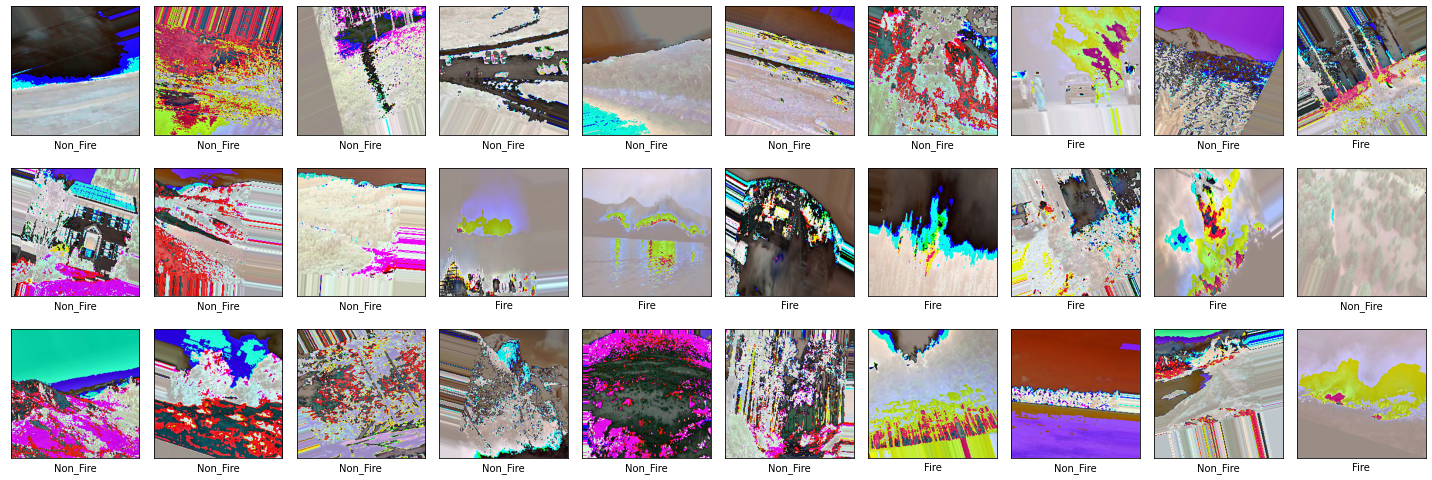

In [7]:
imgs, labels = next(train_batch)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(3,10,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[label.astype('int32')])
    i+=1
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [8]:
validatetion_batch = train_gen.flow_from_directory(
    directory = TRAIN_DATADIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
   class_mode = 'sparse',
    subset='validation',
    seed = SEED
)


Found 920 images belonging to 2 classes.


In [9]:
test_batch = test_gen.flow_from_directory(
    directory = TEST_DATADIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    seed = SEED
)


Found 50 images belonging to 2 classes.


In [10]:
def identity_block(X, filters):
    f1, f2, f3 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [11]:
def conv_blocks(X, filters, s=2):
    f1, f2, f3 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    ### match the dimension
    X_copy = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid')(X_copy)
    X_copy = layers.BatchNormalization(axis=3)(X_copy)
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [12]:
def ResNet50():
    X_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    X = layers.ZeroPadding2D((3,3))(X_input)
    
    # Satge Conv1
    X = layers.Conv2D(64, (7,7), strides=(2,2))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    X = layers.MaxPooling2D((3,3), strides=(2,2))(X)
    
    # stage Conv2_x
    X = conv_blocks(X, filters=[64,64,256], s=1)
    X = identity_block(X, filters=[64,64,256])
    X = identity_block(X, filters=[64,64,256])
    
    # stage Conv3_x
    X = conv_blocks(X, filters=[128,128,512], s=2)
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    
    # stage Conv4_x
    X = conv_blocks(X, filters=[256,256,1024], s=2)
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    
    # stage Conv5_x
    X = conv_blocks(X, filters=[512,512,2048], s=2)
    X = identity_block(X, filters=[512,512,2048])
    X = identity_block(X, filters=[512,512,2048])
    
    
    X = layers.AveragePooling2D((2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(10, activation='softmax', kernel_initializer='he_normal')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model
   

In [13]:
model = ResNet50()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 110, 110, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 110, 110, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

In [14]:
def lr_schedule(epoch):
    lr = 1e-2
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=lr_schedule(0)), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

Learning rate:  0.01


In [16]:
h = model.fit(train_batch, 
              epochs=20,
              steps_per_epoch = TRAIN_EXAMPLES // BATCH_SIZE,
              validation_data = validatetion_batch,
              validation_steps = 920 // BATCH_SIZE,
              callbacks=lr_scheduler,
              verbose=2
             )

Epoch 1/20
Learning rate:  0.01
36/36 - 450s - loss: 8.3422 - accuracy: 0.6055 - val_loss: 30897879040.0000 - val_accuracy: 0.5301
Epoch 2/20
Learning rate:  0.01
36/36 - 445s - loss: 1.0929 - accuracy: 0.7626 - val_loss: 64753260.0000 - val_accuracy: 0.5391
Epoch 3/20
Learning rate:  0.01
36/36 - 458s - loss: 0.6711 - accuracy: 0.7951 - val_loss: 3014450.5000 - val_accuracy: 0.5179
Epoch 4/20
Learning rate:  0.01
36/36 - 448s - loss: 1.0020 - accuracy: 0.7986 - val_loss: 12360.0088 - val_accuracy: 0.5413
Epoch 5/20
Learning rate:  0.01
36/36 - 455s - loss: 0.6683 - accuracy: 0.8646 - val_loss: 1339.5808 - val_accuracy: 0.6038
Epoch 6/20
Learning rate:  0.01
36/36 - 527s - loss: 0.5369 - accuracy: 0.8811 - val_loss: 116.3109 - val_accuracy: 0.6239
Epoch 7/20
Learning rate:  0.01
36/36 - 434s - loss: 0.4906 - accuracy: 0.8898 - val_loss: 7.1207 - val_accuracy: 0.7790
Epoch 8/20
Learning rate:  0.01
36/36 - 426s - loss: 0.3573 - accuracy: 0.9132 - val_loss: 1.2762 - val_accuracy: 0.8527


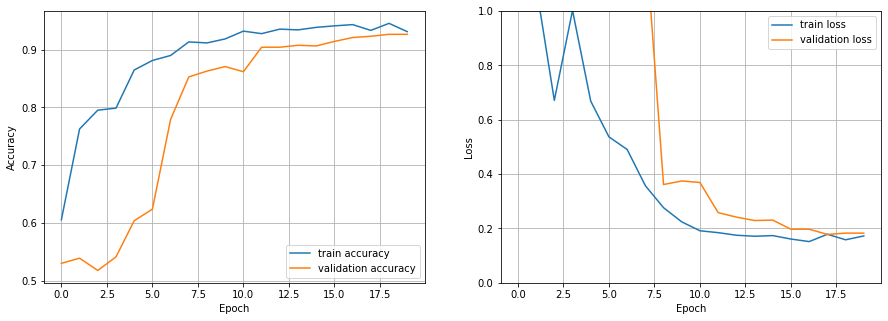

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()

In [18]:
model.save('./data/models/fire_noFire_resNet50.h5')